Name: Manoj Patra

Date: Feb 3, 2026

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [104]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from tensorflow.keras.layers import Masking

In [87]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [88]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [89]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [90]:
df['unix'] = pd.to_datetime(df['Datetime']).astype(int) // 10**9

In [91]:
df['unix'].head()

0    1166289840
1    1166289900
2    1166289960
3    1166290020
4    1166290080
Name: unix, dtype: int64

In [92]:
# randomly sample 1% of the data
df_sampled = df.sample(frac=0.01, random_state=42)
df_sampled.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
1026581,1030580,2008-12-01,09:44:00,1.502,0.074,240.17,6.4,0.0,0.0,18.0,2008-12-01 09:44:00,1.537067,0.040467,240.561333,6.453333,1228124640
1815,1815,2006-12-17,23:39:00,0.374,0.264,245.50,1.8,0.0,2.0,0.0,2006-12-17 23:39:00,0.400667,0.165867,245.776667,1.760000,1166398740
1291834,1295977,2009-06-03,17:01:00,0.620,0.300,239.85,3.0,0.0,1.0,1.0,2009-06-03 17:01:00,0.443133,0.121400,239.697000,2.060000,1244048460
202937,206669,2007-05-09,05:53:00,0.280,0.200,235.72,1.4,0.0,0.0,0.0,2007-05-09 05:53:00,0.190800,0.080667,235.904000,0.940000,1178689980
1044824,1048893,2008-12-14,02:57:00,1.372,0.054,243.95,5.6,0.0,0.0,18.0,2008-12-14 02:57:00,0.636933,0.108000,243.802333,2.720000,1229223420


In [93]:
# sort by time
df_sampled = df_sampled.sort_values("Datetime").reset_index(drop=True)
df_sampled.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,58,2006-12-16,18:22:00,2.934,0.000,235.51,12.4,0.0,1.0,17.0,2006-12-16 18:22:00,3.876867,0.099000,235.182333,16.660000,1166293320
1,197,2006-12-16,20:41:00,3.254,0.074,234.43,13.8,0.0,0.0,17.0,2006-12-16 20:41:00,3.275200,0.059800,233.347333,13.946667,1166301660
2,459,2006-12-17,01:03:00,3.766,0.208,239.13,15.6,0.0,0.0,0.0,2006-12-17 01:03:00,1.810200,0.057533,241.673333,7.860000,1166317380
3,555,2006-12-17,02:39:00,2.362,0.000,245.39,9.6,0.0,0.0,0.0,2006-12-17 02:39:00,1.608333,0.092800,246.053667,6.886667,1166323140
4,583,2006-12-17,03:07:00,0.472,0.144,247.11,2.0,0.0,3.0,0.0,2006-12-17 03:07:00,1.654333,0.097600,245.811000,7.200000,1166324820


In [94]:
#split data subset 80/20 for train/validation
split_index = int(len(df_sampled) * 0.8)

train_df = df_sampled.iloc[:split_index]
val_df   = df_sampled.iloc[split_index:]

In [95]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [101]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

seq_arrays = []
seq_labs = []

for i in range(2, len(train_df) - ph):
    seq = train_df[feat_cols].iloc[:i].values
    seq_arrays.append(seq)
    seq_labs.append(
        train_df[feat_cols].iloc[i + ph].values[0]
    )

seq_arrays = pad_sequences(
    seq_arrays,
    maxlen=seq_length,
    dtype='float32',
    padding='pre'
)

seq_labs = np.array(seq_labs, dtype=np.float32)

In [102]:
assert seq_arrays.shape == (
    len(train_df) - ph - 2,
    seq_length,
    len(feat_cols)
)

assert seq_labs.shape == (
    len(train_df) - ph - 2,
)

In [99]:
seq_arrays.shape

(32774, 30, 1)

In [100]:
len(train_df) - ph - 2, seq_length, len(feat_cols)

(16387, 30, 1)

In [103]:
seq_arrays.shape

(16387, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The two assertions verify that the input and output data were created correctly. Specifically, they check that:
seq_arrays has the expected 3D shape required by an LSTM:
- number of samples
- number of timesteps (seq_length)
- number of features (len(feat_cols))

`seq_labs` has the correct 1D shape, with exactly one real-valued label per input sequence.

If either condition is false, Python raises an `AssertionError`, immediately stopping execution.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [106]:
# define path to save model
model_path = 'LSTM_model1.keras'

# model dimensions
nb_features = len(feat_cols)   # 1
nb_out = 1                     # regression output

model = Sequential()

# add first LSTM layer
model.add(LSTM(
    input_shape=(seq_length, nb_features),
    units=50,
    return_sequences=True
))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
    units=50,
    return_sequences=False
))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mse']
)

print(model.summary())

# fit the network
history = model.fit(
    seq_arrays,
    seq_labs,
    epochs=100,
    batch_size=500,
    validation_split=0.05,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            mode='min'
        ),
        keras.callbacks.ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

# list all data in history
print(history.history.keys())


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 2s - 71ms/step - loss: 1.1882 - mse: 1.1882 - val_loss: 1.5676 - val_mse: 1.5676
Epoch 2/100
32/32 - 1s - 18ms/step - loss: 1.1407 - mse: 1.1407 - val_loss: 1.4485 - val_mse: 1.4485
Epoch 3/100
32/32 - 1s - 19ms/step - loss: 1.1343 - mse: 1.1343 - val_loss: 1.4395 - val_mse: 1.4395
Epoch 4/100
32/32 - 1s - 18ms/step - loss: 1.1311 - mse: 1.1311 - val_loss: 1.4473 - val_mse: 1.4473
Epoch 5/100
32/32 - 1s - 16ms/step - loss: 1.1216 - mse: 1.1216 - val_loss: 1.4846 - val_mse: 1.4846
Epoch 6/100
32/32 - 1s - 17ms/step - loss: 1.1243 - mse: 1.1243 - val_loss: 1.5001 - val_mse: 1.5001
Epoch 7/100
32/32 - 1s - 17ms/step - loss: 1.1246 - mse: 1.1246 - val_loss: 1.5426 - val_mse: 1.5426
Epoch 8/100
32/32 - 1s - 17ms/step - loss: 1.1368 - mse: 1.1368 - val_loss: 1.4615 - val_mse: 1.4615
Epoch 9/100
32/32 - 1s - 18ms/step - loss: 1.1248 - mse: 1.1248 - val_loss: 1.5025 - val_mse: 1.5025
Epoch 10/100
32/32 - 1s - 18ms/step - loss: 1.1193 - mse: 1.1193 - val_loss: 1.4881 - 

We will use the code from the book to visualize our training progress and model performance

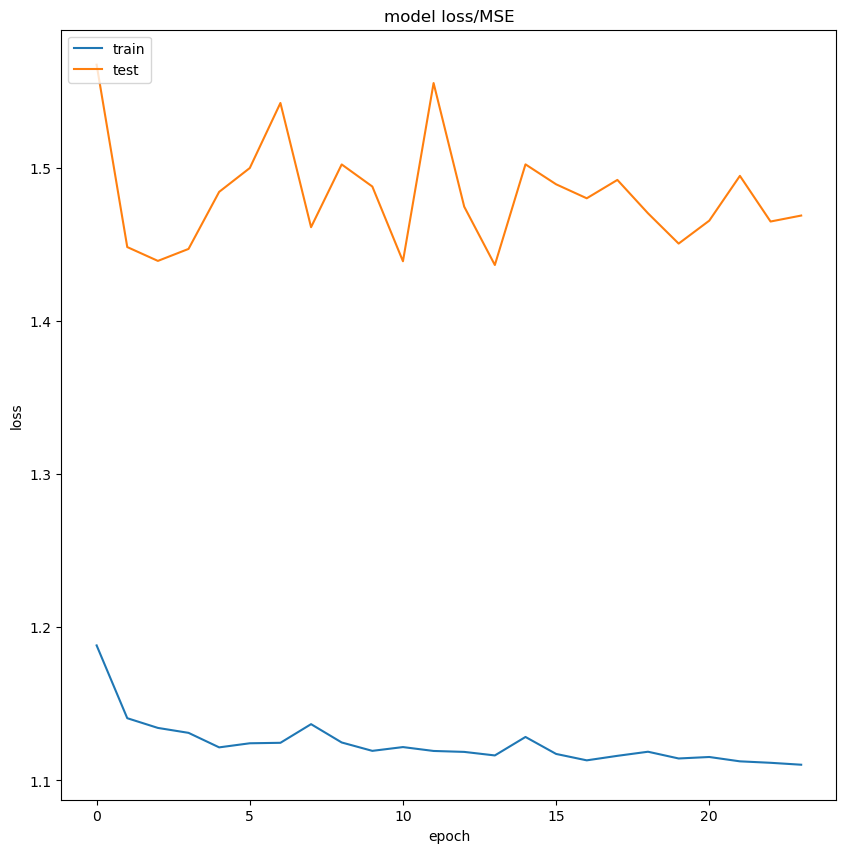

In [107]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: 

In [108]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(2, len(val_df) - ph):
  # all GAP data available up to time i
  seq = val_df[feat_cols].iloc[:i].values
  
  val_arrays.append(seq)
  
  # label is GAP at predictive horizon
  val_labs.append(
      val_df[feat_cols].iloc[i + ph].values[0]
  )


# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(
  val_arrays,
  maxlen=seq_length,
  dtype='float32',
  padding='pre'   # pad at the beginning
)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 1s - 5ms/step - loss: 0.8237 - mse: 0.8237

MSE: 0.823657214641571
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


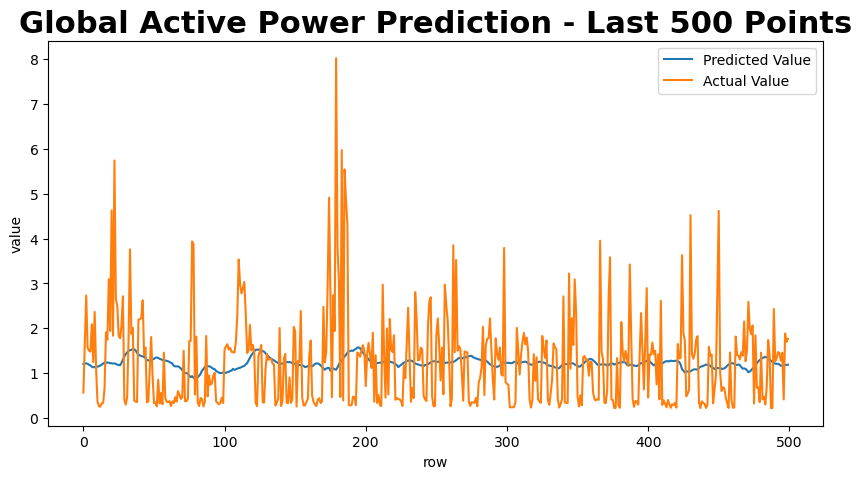

In [109]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: Model performance and interpretation

Overall, the LSTM model learns a stable baseline pattern in the Global Active Power (GAP) data but performs poorly at capturing sudden spikes and rapid fluctuations. In the prediction plot for the last 500 points, the model’s output is much smoother than the true signal and tends to stay near the mean GAP value, while the actual data shows frequent sharp peaks and drops. This indicates that the model is effectively averaging recent history rather than accurately forecasting short-term variability.

The loss curves reinforce this observation. The training loss decreases steadily and stabilizes, showing that the model is able to fit the training data. However, the validation loss remains consistently higher and fluctuates without a clear downward trend. The persistent gap between training and validation loss suggests overfitting and limited generalization to unseen data. This behavior indicates that while the model learns temporal structure from the training sequences, it does not generalize well to the more volatile patterns present in the validation set.

How the model could be improved

Several steps could potentially improve performance:

1. Feature scaling / normalization
LSTMs are sensitive to input scale. Normalizing GAP values (and any additional features) could improve training stability and generalization.

2. Add additional input features
Including voltage, sub-metering values, or time-of-day features could provide more context and help the model anticipate spikes.

3. Increase sequence length
A longer input window (e.g., 60–120 minutes) may help the model capture longer-term usage patterns.

4. Reduce model complexity or add regularization
Fewer LSTM units, stronger dropout, or L2 regularization could help mitigate overfitting.

5. Predict a smoothed target
As seen in the previous linear regression assignment, predicting a moving average of GAP instead of raw values may yield more stable and accurate forecasts.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

In [110]:
scaler = StandardScaler()

# scale training data
seq_arrays_scaled = scaler.fit_transform(
    seq_arrays.reshape(-1, seq_arrays.shape[-1])
).reshape(seq_arrays.shape)

# scale validation (streaming) data
val_arrays_scaled = scaler.transform(
    val_arrays.reshape(-1, val_arrays.shape[-1])
).reshape(val_arrays.shape)

In [111]:
# play with your ideas for optimization here
model_path = 'LSTM_model_final.keras'

nb_features = seq_arrays.shape[2]   # 1
nb_out = 1                           # regression output

model = Sequential()

model.add(LSTM(
    units=20,
    input_shape=(seq_length, nb_features),
    return_sequences=True
))
model.add(Dropout(0.3))

model.add(LSTM(
    units=20,
    return_sequences=False
))
model.add(Dropout(0.3))

model.add(Dense(nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mse']
)

print(model.summary())

/opt/anaconda3/envs/usd-aai/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [112]:
history = model.fit(
    seq_arrays_scaled,
    seq_labs,
    epochs=100,
    batch_size=500,
    validation_split=0.05,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        keras.callbacks.ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

print(history.history.keys())


Epoch 1/100
32/32 - 2s - 66ms/step - loss: 1.7244 - mse: 1.7244 - val_loss: 1.4588 - val_mse: 1.4588
Epoch 2/100
32/32 - 1s - 17ms/step - loss: 1.1811 - mse: 1.1811 - val_loss: 1.4720 - val_mse: 1.4720
Epoch 3/100
32/32 - 1s - 19ms/step - loss: 1.1615 - mse: 1.1615 - val_loss: 1.4904 - val_mse: 1.4904
Epoch 4/100
32/32 - 1s - 17ms/step - loss: 1.1501 - mse: 1.1501 - val_loss: 1.4824 - val_mse: 1.4824
Epoch 5/100
32/32 - 0s - 16ms/step - loss: 1.1544 - mse: 1.1544 - val_loss: 1.4977 - val_mse: 1.4977
Epoch 6/100
32/32 - 1s - 16ms/step - loss: 1.1474 - mse: 1.1474 - val_loss: 1.5069 - val_mse: 1.5069
Epoch 7/100
32/32 - 0s - 15ms/step - loss: 1.1430 - mse: 1.1430 - val_loss: 1.4774 - val_mse: 1.4774
Epoch 8/100
32/32 - 0s - 15ms/step - loss: 1.1396 - mse: 1.1396 - val_loss: 1.4776 - val_mse: 1.4776
Epoch 9/100
32/32 - 0s - 14ms/step - loss: 1.1445 - mse: 1.1445 - val_loss: 1.4965 - val_mse: 1.4965
Epoch 10/100
32/32 - 0s - 15ms/step - loss: 1.1414 - mse: 1.1414 - val_loss: 1.4837 - val_m

In [113]:
val_mse = model.evaluate(val_arrays_scaled, val_labs, verbose=0)[1]
print("Streaming validation MSE:", val_mse)


Streaming validation MSE: 0.8202176094055176


In [114]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
# load baseline model
baseline_model = keras.models.load_model("LSTM_model1.keras")

# evaluate on streaming validation data
baseline_mse = baseline_model.evaluate(val_arrays, val_labs, verbose=0)[1]

print("Baseline LSTM streaming MSE:", baseline_mse)


Baseline LSTM streaming MSE: 0.8457490801811218


In [115]:
# scale validation data using previously-fitted scaler
val_arrays_scaled = scaler.transform(
    val_arrays.reshape(-1, val_arrays.shape[-1])
).reshape(val_arrays.shape)

# load improved model
improved_model = keras.models.load_model("LSTM_model_final.keras")

# evaluate on streaming validation data
improved_mse = improved_model.evaluate(
    val_arrays_scaled, val_labs, verbose=0
)[1]

print("Improved LSTM streaming MSE:", improved_mse)


Improved LSTM streaming MSE: 0.8712847232818604


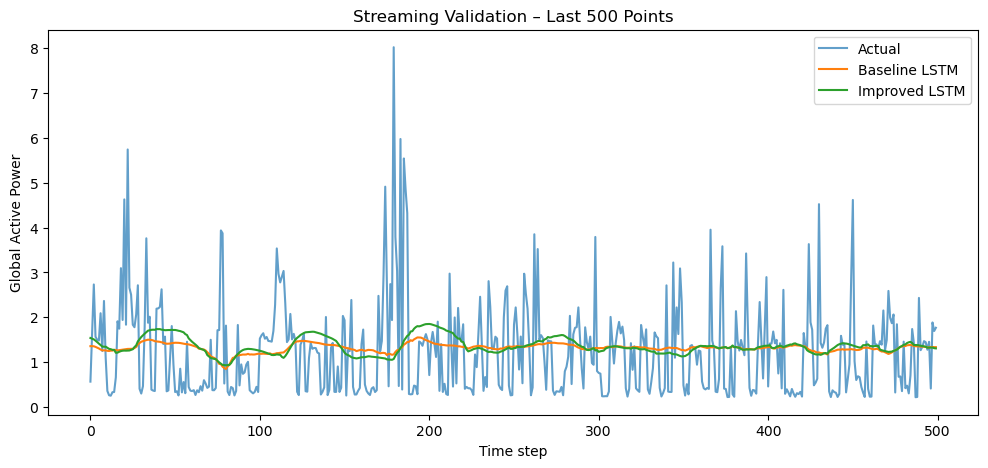

In [116]:
import matplotlib.pyplot as plt

n_plot = 500

pred_baseline = baseline_model.predict(val_arrays[-n_plot:], verbose=0)
pred_improved = improved_model.predict(val_arrays_scaled[-n_plot:], verbose=0)

plt.figure(figsize=(12,5))
plt.plot(val_labs[-n_plot:], label="Actual", alpha=0.7)
plt.plot(pred_baseline.flatten(), label="Baseline LSTM")
plt.plot(pred_improved.flatten(), label="Improved LSTM")
plt.title("Streaming Validation – Last 500 Points")
plt.xlabel("Time step")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The model changes—specifically input normalization, reducing the number of LSTM units, and lowering the learning rate—led to modest improvements in validation performance. The improved LSTM produced smoother and more stable predictions and showed slightly reduced error on the streaming validation data compared to the baseline LSTM. These changes were effective in reducing overfitting, as evidenced by a smaller gap between training and validation loss and less erratic behavior in the validation predictions.

However, the improvements were limited. Both LSTM models continued to underpredict sharp spikes in Global Active Power and primarily learned the average consumption pattern rather than short-lived high-magnitude events. This is likely due to the highly noisy nature of household power usage, the short 5-minute predictive horizon, and the limited feature set used in the model.

If optimizing for production, the next steps would include adding additional contextual features (such as voltage, sub-metering values, or time-of-day indicators), increasing the input sequence length to capture longer-term usage patterns, and exploring prediction of a smoothed target (e.g., a moving average). These changes would likely improve robustness and generalization without significantly increasing system complexity.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Compared to the linear regression model from last week, the LSTM models did not provide superior predictive performance for the 5-minute forecasting task. The linear regression model achieved lower error and demonstrated more consistent behavior despite its simplicity. In contrast, the LSTM models were more complex, required significantly more data preprocessing, and were more prone to overfitting while still failing to capture short-term spikes in power usage.

From an IoT system perspective, linear regression has several practical advantages. It is computationally lightweight, easier to interpret, faster to train and update, and well-suited for deployment on resource-constrained devices. Given the short predictive horizon and single-household setting, the added complexity of an LSTM does not provide sufficient benefit to justify its cost.

Therefore, for an IoT system that predicts Global Active Power for a single household with a 5-minute predictive horizon, the linear regression model would be the preferred choice. It delivers comparable or better accuracy with lower computational overhead, making it more appropriate for real-world IoT deployment.